# 翻译器：从法文到英文

> 原文：https://docs.pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
>
> 本篇笔记用更简洁和现代的 API 重新实现原文的分类器，并实现更好的性能。


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import jieba

%matplotlib inline

torch.manual_seed(9527)

## 1. 数据理解

`data/eng-fra.txt` 是个 txt 文件，文件内容每行为一对英法翻译，英文和法文以 `\t` 隔开。现把每行读出，分割出英法句子，用 [jieba](https://github.com/fxsjy/jieba) 分词，统计词频，去除词频较低或句子较长的语料。


In [2]:
class WordStat:
    @staticmethod
    def split(sentence):
        return tuple(word for word in jieba.cut(sentence.lower()) if word != " ")

    def __init__(self):
        self.pairs, self.fra_w2c, self.eng_w2c = [], {}, {}

    def stat(self, fra, eng):
        pair = WordStat.split(fra), WordStat.split(eng)
        self.pairs.append(pair)
        for word in pair[0]:
            self.fra_w2c[word] = self.fra_w2c.get(word, 0) + 1
        for word in pair[1]:
            self.eng_w2c[word] = self.eng_w2c.get(word, 0) + 1

    def take(self, min_count=1, max_length=10):

        fra_w2c, eng_w2c = dict(self.fra_w2c), dict(self.eng_w2c)

        def predicate(fra, eng):
            fra_map = map(lambda w: self.fra_w2c[w] > min_count, fra)
            eng_map = map(lambda w: self.eng_w2c[w] > min_count, eng)
            to_remove = (
                max(len(fra), len(eng)) > max_length
                or not all(fra_map)
                or not all(eng_map)
            )
            if to_remove:
                for word in fra:
                    fra_w2c[word] -= 1
                for word in eng:
                    eng_w2c[word] -= 1
            return not to_remove

        def sorted_words(w2c):
            sorted_item = sorted(w2c.items(), key=lambda wc: wc[1], reverse=True)
            return [w for w, c in sorted_item if c]

        fra_eng = [pair for pair in self.pairs if predicate(*pair)]

        return fra_eng, sorted_words(fra_w2c), sorted_words(eng_w2c)


word_stat = WordStat()

with open("data/eng-fra.txt", "r", encoding="utf-8") as f:
    for line in f:
        eng, fra = line.split("\t")
        word_stat.stat(fra.strip(), eng.strip())
seq_len = 12
fra_eng, fra_words, eng_words = word_stat.take(min_count=200, max_length=seq_len - 1)
word_stat = None

len(fra_eng), len(fra_words), len(eng_words)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/n8/p2f6qm3n7r17bcv_2chh5q_h0000gn/T/jieba.cache
Loading model cost 0.248 seconds.
Prefix dict has been built successfully.


(14724, 541, 468)

## 2. 模型设计

In [ ]:
class Translator(nn.Module):
    def __init__(self, source_size, target_size, hidden_size, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(source_size, hidden_size, dropout)
        self.decoder = Decoder(target_size, hidden_size, dropout)

    def forward(self, source_input, target_input=None):
        return self.decoder(self.encoder(source_input), target_input)


class Encoder(nn.Module):
    def __init__(self, source_size, hidden_size, dropout):
        super().__init__()
        self.emb = nn.Embedding(source_size, hidden_size)
        self.out = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, source_input):
        return self.gru(self.out(self.emb(source_input)))


class Decoder(nn.Module):
    def __init__(self, target_size, hidden_size, dropout):
        super().__init__()
        self.emb = nn.Embedding(target_size, hidden_size)
        self.out = nn.Dropout(dropout)
        self.att = Attention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.lin = nn.Linear(hidden_size, target_size, bias=False)

    def forward(self, encoded, target_input=None):
        encoder_output, hidden = encoded
        batch_size, seq_len, *_ = encoder_output.shape
        decoder_output = []
        input = torch.zeros(batch_size, 1, dtype=torch.int, device=device)
        for i in range(seq_len):
            output, hidden = self.step(input, hidden, encoder_output)
            decoder_output.append(output)
            if target_input is None:
                input = output.argmax(dim=-1).detach()
            else:
                input = target_input[:, i : i + 1]
        return torch.cat(decoder_output, dim=1)

    def step(self, decoder_input, hidden, encoder_output):
        embedded = self.out(self.emb(decoder_input))
        context = self.att(hidden.permute(1, 0, 2), encoder_output)
        output, hidden = self.gru(torch.cat([embedded, context], dim=-1), hidden)
        return self.lin(output), hidden


class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.wa = nn.Linear(hidden_size, hidden_size)
        self.ua = nn.Linear(hidden_size, hidden_size)
        self.va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.va(F.tanh(self.wa(query) + self.ua(keys)))
        weights = F.softmax(scores.squeeze(2).unsqueeze(1), dim=-1)
        context = weights @ keys
        return context


if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"

source_size, target_size, hidden_size = len(fra_words) + 1, len(eng_words) + 1, 128

model = Translator(source_size, target_size, hidden_size).to(device)

model

Translator(
  (encoder): Encoder(
    (emb): Embedding(542, 128)
    (out): Dropout(p=0.1, inplace=False)
    (gru): GRU(128, 128, batch_first=True)
  )
  (decoder): Decoder(
    (emb): Embedding(469, 128)
    (out): Dropout(p=0.1, inplace=False)
    (att): Attention(
      (wa): Linear(in_features=128, out_features=128, bias=True)
      (ua): Linear(in_features=128, out_features=128, bias=True)
      (va): Linear(in_features=128, out_features=1, bias=True)
    )
    (gru): GRU(256, 128, batch_first=True)
    (lin): Linear(in_features=128, out_features=469, bias=True)
  )
)

## 3. 数据准备

In [4]:
class Dataset(Dataset):
    def __init__(self, fra_eng, fra_words, eng_words):
        self.data = []
        for fra, eng in fra_eng:
            x = [
                fra_words.index(fra[i]) + 1 if i < len(fra) else 0
                for i in range(seq_len)
            ]
            y = [
                eng_words.index(eng[i]) + 1 if i < len(eng) else 0
                for i in range(seq_len)
            ]
            self.data.append((torch.tensor(x), torch.tensor(y)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


batch_size, dataset = 32, Dataset(fra_eng, fra_words, eng_words)

train_data, test_data = random_split(dataset, [len(dataset) - batch_size, batch_size])

dataloader = DataLoader(train_data, batch_size, shuffle=True)

for source, target in dataloader:
    print(source.dtype, target.shape)
    break

torch.int64 torch.Size([32, 12])


## 4. 模型训练

1. 损失函数用 nn.CrossEntropyLoss
2. 优化器用 optim.Adam


Epoch  1/50, Loss: 1.9846131371415179
Epoch  2/50, Loss: 1.2962759409261786
Epoch  3/50, Loss: 1.0427047815011896
Epoch  4/50, Loss: 0.8687745138354923
Epoch  5/50, Loss: 0.7215516677369243
Epoch  6/50, Loss: 0.6147108623515005
Epoch  7/50, Loss: 0.5698010712862015
Epoch  8/50, Loss: 0.5816282663656318
Epoch  9/50, Loss: 0.5361841872982357
Epoch 10/50, Loss: 0.5154203687025153
Epoch 11/50, Loss: 0.4635334938764572
Epoch 12/50, Loss: 0.4235156458357106
Epoch 13/50, Loss: 0.38211904323619345
Epoch 14/50, Loss: 0.3600055843915628
Epoch 15/50, Loss: 0.3317938659826051
Epoch 16/50, Loss: 0.30671859254007755
Epoch 17/50, Loss: 0.28324055917884994
Epoch 18/50, Loss: 0.2668344049026137
Epoch 19/50, Loss: 0.24760580419198328
Epoch 20/50, Loss: 0.23254847111909285
Epoch 21/50, Loss: 0.21880681509880917
Epoch 22/50, Loss: 0.20984834081128886
Epoch 23/50, Loss: 0.20335545010216857
Epoch 24/50, Loss: 0.2087289485918439
Epoch 25/50, Loss: 0.21082865463002867
Epoch 26/50, Loss: 0.20298616068194741
Ep

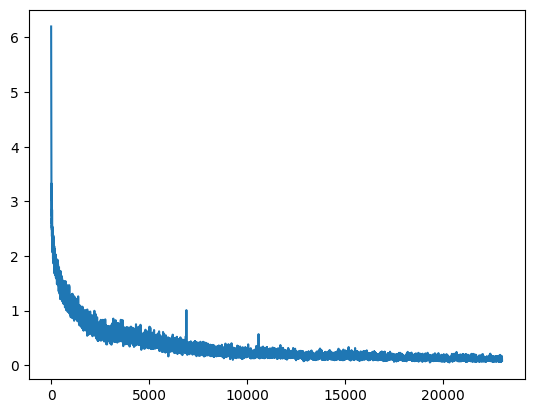

In [ ]:
def train(model, dataloader, epochs=50, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn, losses = nn.CrossEntropyLoss(), []
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            output = model(source, target)
            loss = loss_fn(output.view(-1, output.size(-1)), target.view(-1))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = loss.cpu().item()
            losses.append(loss)
            total_loss += loss
        print(f"Epoch {epoch+1:>2}/{epochs}, Loss: {total_loss / len(dataloader)}")
    return losses


losses = train(model, dataloader)

plt.figure()
plt.plot(losses)
plt.show()

## 5. 模型验证


In [ ]:
@torch.no_grad()
def eval(model, dataloader):
    model.eval()
    outputs = []

    for x, y in dataloader:
        output = model(x.to(device)).argmax(dim=-1).view(-1).cpu().tolist()
        outputs.append(
            (
                [index for index in x.view(-1).tolist() if index],
                [index for index in y.view(-1).tolist() if index],
                [index for index in output if index],
            )
        )

    return outputs


for source, target, output in eval(model, DataLoader(test_data)):
    print("source:", " ".join(fra_words[i - 1] for i in source))
    print("target:", " ".join(eng_words[i - 1] for i in target))
    print("output:", " ".join(eng_words[i - 1] for i in output))
    print()

source: je pr é vois de d é jeuner avec lui .
target: i plan to have lunch with him .
output: i plan to eat there .

source: que veux - tu nous dire ?
target: what is it you want to tell us ?
output: what are you trying to say ?

source: je sais pourquoi tu es ici .
target: i know why you ' re here .
output: i know why you ' re here .

source: je pense que nous devrions attendre .
target: i think we should wait .
output: i think we should wait .

source: en veux - tu encore un ?
target: do you want another one of these ?
output: do you want another one of these ?

source: elle s ' est fait prendre .
target: she got caught .
output: she got caught .

source: je ne peux pas savoir ce que tu penses .
target: i can ' t read your mind .
output: i can ' t understand what you think .

source: vous avez tous fait du bon travail .
target: you all did good work .
output: you all did good work .

source: j ' en ai assez vu .
target: i ' ve had enough of this .
output: i ' ve had enough .

source: